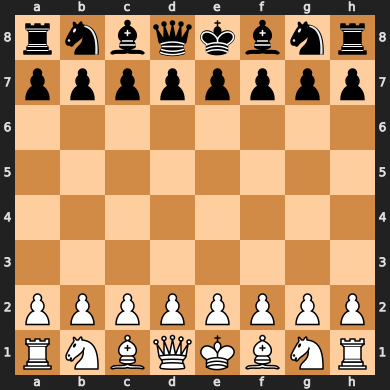

In [1]:
import pickle
from tqdm import tqdm
import numpy as np
import chess
import chess.engine
import chess.pgn
import chess.svg
from IPython.display import *
import datetime 


# engine = chess.engine.SimpleEngine.popen_uci(r"C:\ThefCraft\global-env-exe\stockfish\stockfish-windows-x86-64-avx2.exe")
board = chess.Board()
board

In [2]:
from utils.board import board2vec, board2vec4embeddings

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from io import StringIO 

import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import os
import time

pygame 2.5.0 (SDL 2.28.0, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
import matplotlib.pyplot as plt

In [4]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    state = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(state, filename)


def load_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Loading checkpoint")
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    
    
def calculate_accuracy(predictions, targets):
    with torch.no_grad():
        # Assuming predictions and targets are torch tensors
        predictions = predictions.argmax(dim=1)
        targets = targets.argmax(dim=1)
        correct = (predictions == targets).sum().item()
        total = targets.size(0)
        accuracy = correct / total
    return accuracy

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
%timeit -n 10 -r 10 board2vec4(board)

1.21 ms ± 66.8 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


# DATASET

In [6]:
class CustomDataset(Dataset):
    def __init__(self, file='chess_dataset_1000_new.npz', size=None):
        # Load the dataset
        loaded_data = np.load(file)
        # Extract the arrays
        if size is not None:
            self.X_board_tensor = loaded_data['X_board_tensor'].astype(np.float32)[:size]
            self.X_move_tensor = loaded_data['X_move_tensor'].astype(np.float32)[:size]
            self.Y_who = loaded_data['Y_who'].astype(np.float32)[:size]
            self.Y_where = loaded_data['Y_where'].astype(np.float32)[:size]
        else:
            self.X_board_tensor = loaded_data['X_board_tensor'].astype(np.float32)
            self.X_move_tensor = loaded_data['X_move_tensor'].astype(np.float32)
            self.Y_who = loaded_data['Y_who'].astype(np.float32)
            self.Y_where = loaded_data['Y_where'].astype(np.float32)
        
    def __len__(self): return len(self.X_board_tensor)
    def __getitem__(self, idx): 
        return (self.X_board_tensor[idx], self.X_move_tensor[idx],
                self.Y_who[idx], self.Y_where[idx])

    
# Create an instance of the custom dataset
valid_dataset = CustomDataset(size=100)
# train_dataset = CustomDataset(r'C:\ThefCraft\AI\chess\dataset\1000-10000\chess_dataset_100000_night.npz')
# train_dataset = CustomDataset(r'C:\ThefCraft\AI\chess\dataset\10000-20000\chess_dataset_100000_night.npz')
train_dataset = CustomDataset(r'C:\ThefCraft\AI\chess\dataset\chess_dataset_90000-100000_night.npz')

In [7]:
# Create a DataLoader with batch size 64
batch_size = 4
data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
# # Iterate through the DataLoader
for batch in data_loader:
    board_tensor, move_tensor, who, where = batch
    break

In [8]:
board_tensor, move_tensor = board2vec(board)

# (batch_size, channels, height, width)

board_tensor = torch.from_numpy(board_tensor).unsqueeze(0)
move_tensor = torch.from_numpy(move_tensor).unsqueeze(0)



board_tensor.shape, move_tensor.shape

(torch.Size([1, 12, 8, 8]), torch.Size([1, 12, 8, 8]))

# MODEL

In [9]:
# class ChessModelWhoOLD(nn.Module): # capping on 83% accuracy
#     def __init__(self):
#         super(ChessModelWho, self).__init__()
        
#         self.conv1_board = nn.Conv2d(12, 32, 3, padding=1)
#         self.conv2_board = nn.Conv2d(32, 18, 2)
        
#         self.conv1_move = nn.Conv2d(12, 32, 3, padding=1)
#         self.conv2_move = nn.Conv2d(32, 18, 2)
        
#         self.fc1_board_move = nn.Linear(2*18*7*7, 512)
#         self.fc2_who = nn.Linear(512, 8*8)
#         self.relu = F.relu # lambda x:x
    
#     def forward(self, board_tensor, move_tensor):
#         N = board_tensor.size(0)
         
#         x1 = self.relu(self.conv1_board(board_tensor))
#         x1 = self.relu(self.conv2_board(x1))
#         x2 = self.relu(self.conv1_move(move_tensor))
#         x2 = self.relu(self.conv2_move(x2))
#         x = torch.concat((x1, x2), dim=1).view(N, -1)
#         x = self.relu(self.fc1_board_move(x))
        
#         return self.fc2_who(x)


# and this works ...
class ChessModelWho(nn.Module): # easily acchieveable 99% accuracy
    def __init__(self):
        super(ChessModelWho, self).__init__()
        
        self.conv1_board = nn.Conv2d(12, 32, 3, padding=1)
        self.conv2_board = nn.Conv2d(32, 18, 2)
        self.fc0_board = nn.Linear(18*7*7, 512)
        
        self.conv1_move = nn.Conv2d(12, 32, 3, padding=1)
        self.conv2_move = nn.Conv2d(32, 18, 2)
        self.fc0_move = nn.Linear(18*7*7, 512)
        
        self.fc1_board_move = nn.Linear(2*512, 512)
        self.fc2_who = nn.Linear(512, 256)
        self.fc3_who = nn.Linear(256, 8*8)
        self.relu = F.relu # lambda x:x
    
    def forward(self, board_tensor, move_tensor):
        N = board_tensor.size(0)
         
        x1 = self.relu(self.conv1_board(board_tensor))
        x1 = self.relu(self.conv2_board(x1))
        x1 = self.relu(self.fc0_board(x1.view(N, -1)))
        
        x2 = self.relu(self.conv1_move(move_tensor))
        x2 = self.relu(self.conv2_move(x2))
        x2 = self.relu(self.fc0_move(x2.view(N, -1)))
        
        x = torch.concat((x1, x2), dim=1).view(N, -1)
        x = self.relu(self.fc1_board_move(x))
        x = self.relu(self.fc2_who(x))
        
        return self.fc3_who(x)

X1,X2 = torch.zeros((128,12,8,8)),torch.zeros((128,12,8,8))
ChessModelWho()(X1, X2).shape

torch.Size([128, 64])

In [10]:
class ChessModelWhere(nn.Module): # easily acchieveable 99% accuracy
    def __init__(self):
        super(ChessModelWhere, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.conv1_board = nn.Conv2d(12, 32, 3, padding=1)
        self.conv2_board = nn.Conv2d(32, 18, 2)
        
        self.conv1_move = nn.Conv2d(12, 32, 3, padding=1)
        self.conv2_move = nn.Conv2d(32, 18, 2)
        
        self.fc1_board_move = nn.Linear(2*18*7*7+64, 512)
        self.fc2_who = nn.Linear(512, 8*8)
        self.relu = F.relu # lambda x:x
    
    def forward(self, board_tensor, move_tensor, who): # who is target_who Nx64
        N = board_tensor.size(0)
        x1 = self.relu(self.conv1_board(board_tensor))
        # x1 = self.pool(x1)
        x1 = self.relu(self.conv2_board(x1))
        x2 = self.relu(self.conv1_move(move_tensor))
        # x2 = self.pool(x2)
        x2 = self.relu(self.conv2_move(x2))
        x = torch.concat((x1, x2), dim=1).view(N, -1)
        x = torch.concat((x, who), dim=1)
        x = self.relu(self.fc1_board_move(x))
        return self.fc2_who(x)

X1,X2 = torch.zeros((128,12,8,8)),torch.zeros((128,12,8,8))

ChessModelWhere()(X1, X2, torch.zeros((128,64))).shape

torch.Size([128, 64])

In [11]:
EPOCH = 100
BATCH_SIZE = 4096*16 # i update model weight after each iteration on batch size so make it larger
LR = .002#0.1

In [12]:
modelWHO = ChessModelWho().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelWHO.parameters(), lr=LR) # Adam ?

In [13]:
load_checkpoint(modelWHO, optimizer, 'models\\modelWho_10000-20000_epoch_100_lr_002_accuracy_valid_31_ckpt.pth.tar')

=> Loading checkpoint


In [14]:
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataloader_valid = DataLoader(valid_dataset, batch_size=512, shuffle=True)

In [15]:
losses = []
valid_accuracy = []
modelWHO.train()
for epoch in range(EPOCH):
    for idx, (board_tensor, move_tensor, targetwho, targetwhere) in tqdm(enumerate(dataloader_train), total=dataloader_train.__len__()):
        optimizer.zero_grad()
        board_tensor, move_tensor = board_tensor.to(device), move_tensor.to(device)
        targetwho, targetwhere = targetwho.to(device), targetwhere.to(device)
        who = modelWHO(board_tensor, move_tensor)#, targetwho, targetwhere)
        total_loss = criterion(who, targetwho)
        total_loss.backward()
        losses.append(f'{total_loss}')
        optimizer.step()
        if idx%50 == 0:
            modelWHO.eval()
            # Calculate accuracy
            accuracy = []
            for idx, (board_tensor_valid, move_tensor_valid, targetwho_valid, targetwhere_valid) in enumerate(dataloader_valid):
                board_tensor_valid, move_tensor_valid = board_tensor_valid.to(device), move_tensor_valid.to(device)
                targetwho_valid, targetwhere_valid = targetwho_valid.to(device), targetwhere_valid.to(device)
                with torch.no_grad():
                    who = modelWHO(board_tensor_valid, move_tensor_valid)
                accuracy_who = calculate_accuracy(who, targetwho_valid)
                accuracy.append(accuracy_who)
            accuracy = sum(accuracy)/len(accuracy)
            valid_accuracy.append(f'{accuracy}')
            print(f"{epoch} : Accuracy (WHO): {accuracy * 100:.2f}% | total loss = {total_loss}")
            modelWHO.train()

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:07<03:01,  7.56s/it]

0 : Accuracy (WHO): 32.00% | total loss = 1.339775800704956


  4%|▍         | 1/25 [00:03<01:15,  3.13s/it]

1 : Accuracy (WHO): 33.00% | total loss = 1.2346487045288086


  4%|▍         | 1/25 [00:02<01:03,  2.64s/it]

2 : Accuracy (WHO): 32.00% | total loss = 1.196204423904419


  4%|▍         | 1/25 [00:02<00:55,  2.32s/it]

3 : Accuracy (WHO): 34.00% | total loss = 1.1769919395446777


  4%|▍         | 1/25 [00:02<00:54,  2.26s/it]

4 : Accuracy (WHO): 34.00% | total loss = 1.1674035787582397


  4%|▍         | 1/25 [00:02<00:57,  2.38s/it]

5 : Accuracy (WHO): 31.00% | total loss = 1.1581803560256958


  4%|▍         | 1/25 [00:02<00:52,  2.20s/it]

6 : Accuracy (WHO): 30.00% | total loss = 1.1444041728973389


  4%|▍         | 1/25 [00:02<01:05,  2.73s/it]

7 : Accuracy (WHO): 31.00% | total loss = 1.146867036819458


  4%|▍         | 1/25 [00:02<00:56,  2.36s/it]

8 : Accuracy (WHO): 35.00% | total loss = 1.1386194229125977


  4%|▍         | 1/25 [00:02<00:52,  2.18s/it]

9 : Accuracy (WHO): 31.00% | total loss = 1.13737154006958


  4%|▍         | 1/25 [00:02<00:59,  2.46s/it]

10 : Accuracy (WHO): 33.00% | total loss = 1.1347522735595703


  4%|▍         | 1/25 [00:02<00:57,  2.38s/it]

11 : Accuracy (WHO): 30.00% | total loss = 1.121728539466858


  4%|▍         | 1/25 [00:02<00:56,  2.37s/it]

12 : Accuracy (WHO): 30.00% | total loss = 1.1165103912353516


  4%|▍         | 1/25 [00:02<00:52,  2.19s/it]

13 : Accuracy (WHO): 29.00% | total loss = 1.1068940162658691


  4%|▍         | 1/25 [00:02<01:07,  2.79s/it]

14 : Accuracy (WHO): 29.00% | total loss = 1.1084551811218262


  4%|▍         | 1/25 [00:01<00:46,  1.95s/it]

15 : Accuracy (WHO): 29.00% | total loss = 1.1064543724060059


  4%|▍         | 1/25 [00:02<00:52,  2.17s/it]

16 : Accuracy (WHO): 34.00% | total loss = 1.1115447282791138


  4%|▍         | 1/25 [00:02<00:51,  2.13s/it]

17 : Accuracy (WHO): 27.00% | total loss = 1.1022520065307617


  4%|▍         | 1/25 [00:01<00:44,  1.86s/it]

18 : Accuracy (WHO): 30.00% | total loss = 1.1095917224884033


  4%|▍         | 1/25 [00:01<00:44,  1.86s/it]

19 : Accuracy (WHO): 29.00% | total loss = 1.0989935398101807


  4%|▍         | 1/25 [00:01<00:44,  1.85s/it]

20 : Accuracy (WHO): 29.00% | total loss = 1.0991417169570923


  4%|▍         | 1/25 [00:01<00:43,  1.83s/it]

21 : Accuracy (WHO): 29.00% | total loss = 1.096022129058838


  4%|▍         | 1/25 [00:01<00:44,  1.85s/it]

22 : Accuracy (WHO): 31.00% | total loss = 1.1008281707763672


  4%|▍         | 1/25 [00:01<00:44,  1.87s/it]

23 : Accuracy (WHO): 30.00% | total loss = 1.090247392654419


  4%|▍         | 1/25 [00:01<00:43,  1.79s/it]

24 : Accuracy (WHO): 30.00% | total loss = 1.086789846420288


  4%|▍         | 1/25 [00:01<00:44,  1.84s/it]

25 : Accuracy (WHO): 30.00% | total loss = 1.068530559539795


  4%|▍         | 1/25 [00:01<00:44,  1.86s/it]

26 : Accuracy (WHO): 30.00% | total loss = 1.0796706676483154


  4%|▍         | 1/25 [00:01<00:41,  1.71s/it]

27 : Accuracy (WHO): 32.00% | total loss = 1.079544186592102


  4%|▍         | 1/25 [00:01<00:42,  1.75s/it]

28 : Accuracy (WHO): 27.00% | total loss = 1.0816266536712646


  4%|▍         | 1/25 [00:01<00:44,  1.86s/it]

29 : Accuracy (WHO): 26.00% | total loss = 1.0800259113311768


  4%|▍         | 1/25 [00:02<00:51,  2.14s/it]

30 : Accuracy (WHO): 30.00% | total loss = 1.0735406875610352


  4%|▍         | 1/25 [00:02<00:55,  2.30s/it]

31 : Accuracy (WHO): 31.00% | total loss = 1.0781654119491577


  4%|▍         | 1/25 [00:02<00:50,  2.11s/it]

32 : Accuracy (WHO): 30.00% | total loss = 1.0671330690383911


  4%|▍         | 1/25 [00:01<00:43,  1.81s/it]

33 : Accuracy (WHO): 30.00% | total loss = 1.0706285238265991


  4%|▍         | 1/25 [00:01<00:44,  1.87s/it]

34 : Accuracy (WHO): 27.00% | total loss = 1.064858078956604


  4%|▍         | 1/25 [00:01<00:47,  1.97s/it]

35 : Accuracy (WHO): 29.00% | total loss = 1.059234619140625


  4%|▍         | 1/25 [00:02<00:48,  2.04s/it]

36 : Accuracy (WHO): 32.00% | total loss = 1.0615088939666748


  4%|▍         | 1/25 [00:01<00:44,  1.85s/it]

37 : Accuracy (WHO): 30.00% | total loss = 1.0569579601287842


  4%|▍         | 1/25 [00:02<00:49,  2.06s/it]

38 : Accuracy (WHO): 28.00% | total loss = 1.047327995300293


  4%|▍         | 1/25 [00:01<00:42,  1.76s/it]

39 : Accuracy (WHO): 28.00% | total loss = 1.059852123260498


  4%|▍         | 1/25 [00:01<00:45,  1.88s/it]

40 : Accuracy (WHO): 30.00% | total loss = 1.0467802286148071


  4%|▍         | 1/25 [00:01<00:43,  1.82s/it]

41 : Accuracy (WHO): 26.00% | total loss = 1.0493546724319458


  4%|▍         | 1/25 [00:01<00:44,  1.85s/it]

42 : Accuracy (WHO): 29.00% | total loss = 1.0470082759857178


  4%|▍         | 1/25 [00:01<00:41,  1.73s/it]

43 : Accuracy (WHO): 29.00% | total loss = 1.0425763130187988


  4%|▍         | 1/25 [00:01<00:43,  1.81s/it]

44 : Accuracy (WHO): 28.00% | total loss = 1.051957130432129


  4%|▍         | 1/25 [00:01<00:41,  1.71s/it]

45 : Accuracy (WHO): 29.00% | total loss = 1.0434463024139404


  4%|▍         | 1/25 [00:01<00:43,  1.81s/it]

46 : Accuracy (WHO): 33.00% | total loss = 1.0391643047332764


  4%|▍         | 1/25 [00:02<00:49,  2.05s/it]

47 : Accuracy (WHO): 28.00% | total loss = 1.033221960067749


  4%|▍         | 1/25 [00:01<00:43,  1.81s/it]

48 : Accuracy (WHO): 27.00% | total loss = 1.0397372245788574


  4%|▍         | 1/25 [00:01<00:45,  1.91s/it]

49 : Accuracy (WHO): 25.00% | total loss = 1.0377947092056274


  4%|▍         | 1/25 [00:01<00:44,  1.84s/it]

50 : Accuracy (WHO): 28.00% | total loss = 1.034606695175171


  4%|▍         | 1/25 [00:01<00:46,  1.92s/it]

51 : Accuracy (WHO): 32.00% | total loss = 1.0317000150680542


  4%|▍         | 1/25 [00:01<00:45,  1.89s/it]

52 : Accuracy (WHO): 29.00% | total loss = 1.0200743675231934


  4%|▍         | 1/25 [00:02<00:50,  2.10s/it]

53 : Accuracy (WHO): 25.00% | total loss = 1.0315345525741577


  4%|▍         | 1/25 [00:01<00:47,  2.00s/it]

54 : Accuracy (WHO): 27.00% | total loss = 1.0193467140197754


  4%|▍         | 1/25 [00:01<00:44,  1.85s/it]

55 : Accuracy (WHO): 29.00% | total loss = 1.0226774215698242


  4%|▍         | 1/25 [00:01<00:47,  1.97s/it]

56 : Accuracy (WHO): 33.00% | total loss = 1.0203789472579956


  4%|▍         | 1/25 [00:01<00:44,  1.87s/it]

57 : Accuracy (WHO): 27.00% | total loss = 1.022524118423462


  4%|▍         | 1/25 [00:02<00:53,  2.25s/it]

58 : Accuracy (WHO): 33.00% | total loss = 1.0263776779174805


  4%|▍         | 1/25 [00:01<00:47,  1.97s/it]

59 : Accuracy (WHO): 30.00% | total loss = 1.0239163637161255


  4%|▍         | 1/25 [00:02<00:50,  2.10s/it]

60 : Accuracy (WHO): 30.00% | total loss = 1.0056240558624268


  4%|▍         | 1/25 [00:02<00:48,  2.00s/it]

61 : Accuracy (WHO): 26.00% | total loss = 1.022303581237793


  4%|▍         | 1/25 [00:02<00:49,  2.05s/it]

62 : Accuracy (WHO): 26.00% | total loss = 1.0013751983642578


  4%|▍         | 1/25 [00:01<00:45,  1.90s/it]

63 : Accuracy (WHO): 30.00% | total loss = 1.0126452445983887


  4%|▍         | 1/25 [00:02<00:53,  2.23s/it]

64 : Accuracy (WHO): 27.00% | total loss = 1.0096476078033447


  4%|▍         | 1/25 [00:02<00:53,  2.22s/it]

65 : Accuracy (WHO): 29.00% | total loss = 1.0051637887954712


  4%|▍         | 1/25 [00:01<00:46,  1.92s/it]

66 : Accuracy (WHO): 25.00% | total loss = 1.0069849491119385


  4%|▍         | 1/25 [00:01<00:47,  1.96s/it]

67 : Accuracy (WHO): 27.00% | total loss = 0.9986449480056763


  4%|▍         | 1/25 [00:01<00:46,  1.96s/it]

68 : Accuracy (WHO): 28.00% | total loss = 0.9989422559738159


  4%|▍         | 1/25 [00:02<00:54,  2.27s/it]

69 : Accuracy (WHO): 29.00% | total loss = 0.9945323467254639


  4%|▍         | 1/25 [00:02<00:57,  2.39s/it]

70 : Accuracy (WHO): 28.00% | total loss = 0.9874943494796753


  4%|▍         | 1/25 [00:02<00:51,  2.16s/it]

71 : Accuracy (WHO): 29.00% | total loss = 0.991026759147644


  4%|▍         | 1/25 [00:02<00:55,  2.31s/it]

72 : Accuracy (WHO): 31.00% | total loss = 0.9916672706604004


  4%|▍         | 1/25 [00:02<00:49,  2.05s/it]

73 : Accuracy (WHO): 27.00% | total loss = 0.9916532635688782


  4%|▍         | 1/25 [00:01<00:45,  1.91s/it]

74 : Accuracy (WHO): 30.00% | total loss = 0.9836596250534058


  4%|▍         | 1/25 [00:01<00:46,  1.95s/it]

75 : Accuracy (WHO): 27.00% | total loss = 0.9888839721679688


  4%|▍         | 1/25 [00:01<00:44,  1.86s/it]

76 : Accuracy (WHO): 26.00% | total loss = 0.9907561540603638


  4%|▍         | 1/25 [00:01<00:44,  1.87s/it]

77 : Accuracy (WHO): 32.00% | total loss = 0.9854600429534912


  4%|▍         | 1/25 [00:01<00:45,  1.91s/it]

78 : Accuracy (WHO): 30.00% | total loss = 0.9850654602050781


  4%|▍         | 1/25 [00:01<00:43,  1.80s/it]

79 : Accuracy (WHO): 28.00% | total loss = 0.9837010502815247


  4%|▍         | 1/25 [00:01<00:44,  1.86s/it]

80 : Accuracy (WHO): 26.00% | total loss = 0.9850755929946899


  4%|▍         | 1/25 [00:01<00:46,  1.92s/it]

81 : Accuracy (WHO): 29.00% | total loss = 0.9725844860076904


  4%|▍         | 1/25 [00:01<00:44,  1.84s/it]

82 : Accuracy (WHO): 26.00% | total loss = 0.9787005186080933


  4%|▍         | 1/25 [00:01<00:44,  1.86s/it]

83 : Accuracy (WHO): 29.00% | total loss = 0.9787256717681885


  4%|▍         | 1/25 [00:01<00:42,  1.77s/it]

84 : Accuracy (WHO): 32.00% | total loss = 0.9803245663642883


  4%|▍         | 1/25 [00:02<00:51,  2.13s/it]

85 : Accuracy (WHO): 24.00% | total loss = 0.9795888662338257


  4%|▍         | 1/25 [00:01<00:46,  1.92s/it]

86 : Accuracy (WHO): 26.00% | total loss = 0.9662032723426819


  4%|▍         | 1/25 [00:01<00:44,  1.87s/it]

87 : Accuracy (WHO): 28.00% | total loss = 0.9783834218978882


  4%|▍         | 1/25 [00:01<00:46,  1.95s/it]

88 : Accuracy (WHO): 28.00% | total loss = 0.9723227620124817


  4%|▍         | 1/25 [00:02<00:48,  2.02s/it]

89 : Accuracy (WHO): 27.00% | total loss = 0.9688014388084412


  4%|▍         | 1/25 [00:01<00:45,  1.88s/it]

90 : Accuracy (WHO): 29.00% | total loss = 0.9689065217971802


  4%|▍         | 1/25 [00:01<00:46,  1.94s/it]

91 : Accuracy (WHO): 30.00% | total loss = 0.9676122665405273


  4%|▍         | 1/25 [00:01<00:42,  1.79s/it]

92 : Accuracy (WHO): 30.00% | total loss = 0.9789093732833862


  4%|▍         | 1/25 [00:01<00:47,  1.99s/it]

93 : Accuracy (WHO): 29.00% | total loss = 0.963927149772644


  4%|▍         | 1/25 [00:01<00:44,  1.84s/it]

94 : Accuracy (WHO): 31.00% | total loss = 0.9567716121673584


  4%|▍         | 1/25 [00:02<00:49,  2.05s/it]

95 : Accuracy (WHO): 32.00% | total loss = 0.9577827453613281


  4%|▍         | 1/25 [00:01<00:42,  1.76s/it]

96 : Accuracy (WHO): 31.00% | total loss = 0.9506786465644836


  4%|▍         | 1/25 [00:01<00:45,  1.89s/it]

97 : Accuracy (WHO): 27.00% | total loss = 0.9545557498931885


  4%|▍         | 1/25 [00:01<00:44,  1.87s/it]

98 : Accuracy (WHO): 29.00% | total loss = 0.9614691734313965


  4%|▍         | 1/25 [00:01<00:40,  1.68s/it]

99 : Accuracy (WHO): 25.00% | total loss = 0.9548249840736389


100%|██████████| 25/25 [00:46<00:00,  1.84s/it]


In [20]:
modelWHO.eval()
# Calculate accuracy
accuracy = []
for idx, (board_tensor_valid, move_tensor_valid, targetwho_valid, targetwhere_valid) in tqdm(enumerate(dataloader_train), total=dataloader_train.__len__()):
    board_tensor_valid, move_tensor_valid = board_tensor_valid.to(device), move_tensor_valid.to(device)
    targetwho_valid, targetwhere_valid = targetwho_valid.to(device), targetwhere_valid.to(device)
    with torch.no_grad():
        who = modelWHO(board_tensor_valid, move_tensor_valid)
    accuracy_who = calculate_accuracy(who, targetwho_valid)
    accuracy.append(accuracy_who)
accuracy = sum(accuracy)/len(accuracy)
print(f"{epoch} : Accuracy (WHO) on train data: {accuracy * 100:.2f}%")


Exception ignored in: <function tqdm.__del__ at 0x0000018E87489240>
Traceback (most recent call last):
  File "c:\Users\laksh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "c:\Users\laksh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\std.py", line 1274, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'




















100%|██████████| 20/20 [01:20<00:00,  4.02s/it]

99 : Accuracy (WHO) on train data: 58.35%


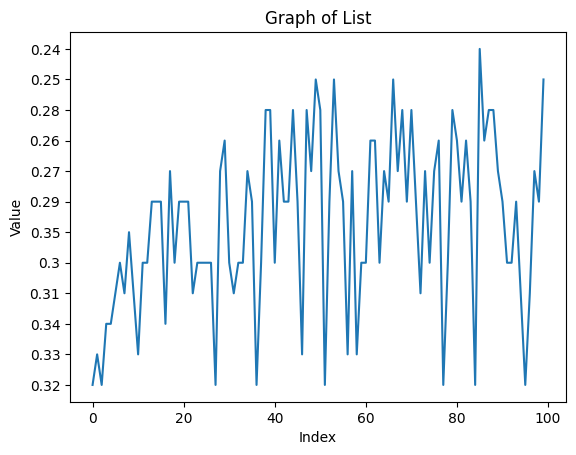

In [22]:
# Plotting the graph
plt.plot(valid_accuracy)

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Graph of List')

# Show the plot
plt.show()

In [16]:
save_checkpoint(modelWHO, optimizer, filename='models\\modelWho_100000_epoch_100_lr_002_accuracy_valid__ckpt.pth.tar')

=> Saving checkpoint


In [17]:
modelWhere = ChessModelWhere().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelWhere.parameters(), lr=LR) # Adam ?

In [18]:
load_checkpoint(modelWhere, optimizer, 'models\\modelWhere_1000-10000_epoch_100_lr_002_accuracy_valid_60_ckpt.pth.tar')

=> Loading checkpoint


In [19]:
modelWhere.train()

lossesWhere = []
valid_accuracyWhere = []
modelWhere.train()
for epoch in range(EPOCH):
    for idx, (board_tensor, move_tensor, targetwho, targetwhere) in tqdm(enumerate(dataloader_train), total=dataloader_train.__len__()):
        optimizer.zero_grad()
        board_tensor, move_tensor = board_tensor.to(device), move_tensor.to(device)
        targetwho, targetwhere = targetwho.to(device), targetwhere.to(device)
        where = modelWhere(board_tensor, move_tensor, targetwho)#, targetwho, targetwhere)
        total_loss = criterion(where, targetwhere)
        total_loss.backward()
        lossesWhere.append(f'{total_loss}')
        optimizer.step()
        if idx%50 == 0:
            modelWhere.eval()
            # Calculate accuracy
            accuracy = []
            for idx, (board_tensor_valid, move_tensor_valid, targetwho_valid, targetwhere_valid) in enumerate(dataloader_valid):
                board_tensor_valid, move_tensor_valid = board_tensor_valid.to(device), move_tensor_valid.to(device)
                targetwho_valid, targetwhere_valid = targetwho_valid.to(device), targetwhere_valid.to(device)
                with torch.no_grad():
                    where = modelWhere(board_tensor_valid, move_tensor_valid, targetwho_valid)
                accuracy_where = calculate_accuracy(where, targetwhere_valid)
                accuracy.append(accuracy_where)
            accuracy = sum(accuracy)/len(accuracy)
            valid_accuracyWhere.append(f'{accuracy}')
            print(f"{epoch} : Accuracy (WHO): {accuracy * 100:.2f}% | total loss = {total_loss}")
            modelWhere.train()

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:02<00:54,  2.27s/it]

0 : Accuracy (WHO): 59.00% | total loss = 1.5023653507232666


  4%|▍         | 1/25 [00:01<00:46,  1.94s/it]

1 : Accuracy (WHO): 59.00% | total loss = 1.4495806694030762


  4%|▍         | 1/25 [00:01<00:42,  1.76s/it]

2 : Accuracy (WHO): 58.00% | total loss = 1.430257797241211


  4%|▍         | 1/25 [00:01<00:46,  1.95s/it]

3 : Accuracy (WHO): 62.00% | total loss = 1.4186629056930542


  4%|▍         | 1/25 [00:01<00:44,  1.84s/it]

4 : Accuracy (WHO): 57.00% | total loss = 1.4037808179855347


  4%|▍         | 1/25 [00:02<00:48,  2.04s/it]

5 : Accuracy (WHO): 58.00% | total loss = 1.3975191116333008


  4%|▍         | 1/25 [00:01<00:45,  1.91s/it]

6 : Accuracy (WHO): 54.00% | total loss = 1.390319585800171


  4%|▍         | 1/25 [00:01<00:45,  1.88s/it]

7 : Accuracy (WHO): 57.00% | total loss = 1.388481616973877


  4%|▍         | 1/25 [00:01<00:43,  1.82s/it]

8 : Accuracy (WHO): 58.00% | total loss = 1.3737380504608154


  4%|▍         | 1/25 [00:01<00:41,  1.74s/it]

9 : Accuracy (WHO): 58.00% | total loss = 1.381908893585205


  4%|▍         | 1/25 [00:01<00:47,  1.99s/it]

10 : Accuracy (WHO): 57.00% | total loss = 1.3784873485565186


  4%|▍         | 1/25 [00:01<00:45,  1.91s/it]

11 : Accuracy (WHO): 59.00% | total loss = 1.3649864196777344


  4%|▍         | 1/25 [00:02<00:48,  2.02s/it]

12 : Accuracy (WHO): 54.00% | total loss = 1.3733962774276733


  4%|▍         | 1/25 [00:01<00:43,  1.83s/it]

13 : Accuracy (WHO): 59.00% | total loss = 1.3640177249908447


  4%|▍         | 1/25 [00:01<00:46,  1.95s/it]

14 : Accuracy (WHO): 54.00% | total loss = 1.3548707962036133


  4%|▍         | 1/25 [00:01<00:41,  1.72s/it]

15 : Accuracy (WHO): 55.00% | total loss = 1.3567390441894531


  4%|▍         | 1/25 [00:01<00:46,  1.93s/it]

16 : Accuracy (WHO): 51.00% | total loss = 1.3447762727737427


  4%|▍         | 1/25 [00:01<00:41,  1.74s/it]

17 : Accuracy (WHO): 55.00% | total loss = 1.3404695987701416


  4%|▍         | 1/25 [00:01<00:42,  1.76s/it]

18 : Accuracy (WHO): 58.00% | total loss = 1.3370932340621948


  4%|▍         | 1/25 [00:01<00:44,  1.86s/it]

19 : Accuracy (WHO): 58.00% | total loss = 1.338425636291504


  4%|▍         | 1/25 [00:01<00:38,  1.60s/it]

20 : Accuracy (WHO): 52.00% | total loss = 1.3335771560668945


  4%|▍         | 1/25 [00:01<00:42,  1.76s/it]

21 : Accuracy (WHO): 57.00% | total loss = 1.3292944431304932


  4%|▍         | 1/25 [00:01<00:44,  1.85s/it]

22 : Accuracy (WHO): 56.00% | total loss = 1.3289918899536133


  4%|▍         | 1/25 [00:01<00:46,  1.93s/it]

23 : Accuracy (WHO): 54.00% | total loss = 1.3342615365982056


  4%|▍         | 1/25 [00:01<00:45,  1.88s/it]

24 : Accuracy (WHO): 56.00% | total loss = 1.3287758827209473


  4%|▍         | 1/25 [00:01<00:43,  1.80s/it]

25 : Accuracy (WHO): 58.00% | total loss = 1.3266222476959229


  4%|▍         | 1/25 [00:01<00:41,  1.74s/it]

26 : Accuracy (WHO): 52.00% | total loss = 1.3286426067352295


  4%|▍         | 1/25 [00:01<00:45,  1.91s/it]

27 : Accuracy (WHO): 53.00% | total loss = 1.3189594745635986


  4%|▍         | 1/25 [00:01<00:43,  1.83s/it]

28 : Accuracy (WHO): 56.00% | total loss = 1.3152859210968018


  4%|▍         | 1/25 [00:01<00:45,  1.88s/it]

29 : Accuracy (WHO): 59.00% | total loss = 1.3187255859375


  4%|▍         | 1/25 [00:01<00:44,  1.87s/it]

30 : Accuracy (WHO): 54.00% | total loss = 1.3102061748504639


  4%|▍         | 1/25 [00:01<00:44,  1.87s/it]

31 : Accuracy (WHO): 57.00% | total loss = 1.3146171569824219


  4%|▍         | 1/25 [00:01<00:43,  1.82s/it]

32 : Accuracy (WHO): 56.00% | total loss = 1.3106920719146729


  4%|▍         | 1/25 [00:01<00:45,  1.90s/it]

33 : Accuracy (WHO): 57.00% | total loss = 1.3062865734100342


  4%|▍         | 1/25 [00:01<00:46,  1.95s/it]

34 : Accuracy (WHO): 55.00% | total loss = 1.3144346475601196


  4%|▍         | 1/25 [00:01<00:41,  1.73s/it]

35 : Accuracy (WHO): 58.00% | total loss = 1.307483434677124


  4%|▍         | 1/25 [00:01<00:43,  1.82s/it]

36 : Accuracy (WHO): 58.00% | total loss = 1.2957468032836914


  4%|▍         | 1/25 [00:01<00:42,  1.79s/it]

37 : Accuracy (WHO): 57.00% | total loss = 1.3006062507629395


  4%|▍         | 1/25 [00:01<00:43,  1.79s/it]

38 : Accuracy (WHO): 61.00% | total loss = 1.2933356761932373


  4%|▍         | 1/25 [00:01<00:44,  1.86s/it]

39 : Accuracy (WHO): 61.00% | total loss = 1.2913450002670288


  4%|▍         | 1/25 [00:01<00:40,  1.68s/it]

40 : Accuracy (WHO): 58.00% | total loss = 1.2908318042755127


  4%|▍         | 1/25 [00:01<00:41,  1.75s/it]

41 : Accuracy (WHO): 56.00% | total loss = 1.2901678085327148


  4%|▍         | 1/25 [00:01<00:45,  1.90s/it]

42 : Accuracy (WHO): 62.00% | total loss = 1.2854574918746948


  4%|▍         | 1/25 [00:01<00:43,  1.82s/it]

43 : Accuracy (WHO): 56.00% | total loss = 1.2855234146118164


  4%|▍         | 1/25 [00:01<00:45,  1.88s/it]

44 : Accuracy (WHO): 58.00% | total loss = 1.2825639247894287


  4%|▍         | 1/25 [00:01<00:45,  1.88s/it]

45 : Accuracy (WHO): 57.00% | total loss = 1.2791056632995605


  4%|▍         | 1/25 [00:02<00:54,  2.27s/it]

46 : Accuracy (WHO): 58.00% | total loss = 1.2840168476104736


  4%|▍         | 1/25 [00:02<00:49,  2.07s/it]

47 : Accuracy (WHO): 58.00% | total loss = 1.2901787757873535


  4%|▍         | 1/25 [00:01<00:41,  1.71s/it]

48 : Accuracy (WHO): 59.00% | total loss = 1.271327018737793


  4%|▍         | 1/25 [00:01<00:43,  1.82s/it]

49 : Accuracy (WHO): 55.00% | total loss = 1.277268648147583


  4%|▍         | 1/25 [00:01<00:41,  1.74s/it]

50 : Accuracy (WHO): 58.00% | total loss = 1.2814905643463135


  4%|▍         | 1/25 [00:01<00:44,  1.85s/it]

51 : Accuracy (WHO): 58.00% | total loss = 1.2717097997665405


  4%|▍         | 1/25 [00:01<00:45,  1.89s/it]

52 : Accuracy (WHO): 56.00% | total loss = 1.2713189125061035


  4%|▍         | 1/25 [00:01<00:45,  1.92s/it]

53 : Accuracy (WHO): 59.00% | total loss = 1.2793326377868652


  4%|▍         | 1/25 [00:01<00:45,  1.89s/it]

54 : Accuracy (WHO): 60.00% | total loss = 1.2607001066207886


  4%|▍         | 1/25 [00:01<00:45,  1.89s/it]

55 : Accuracy (WHO): 60.00% | total loss = 1.2667418718338013


  4%|▍         | 1/25 [00:01<00:45,  1.90s/it]

56 : Accuracy (WHO): 56.00% | total loss = 1.265005350112915


  4%|▍         | 1/25 [00:01<00:45,  1.91s/it]

57 : Accuracy (WHO): 57.00% | total loss = 1.2630107402801514


  4%|▍         | 1/25 [00:01<00:44,  1.86s/it]

58 : Accuracy (WHO): 60.00% | total loss = 1.2666674852371216


  4%|▍         | 1/25 [00:02<00:48,  2.01s/it]

59 : Accuracy (WHO): 60.00% | total loss = 1.2518374919891357


  4%|▍         | 1/25 [00:01<00:40,  1.70s/it]

60 : Accuracy (WHO): 60.00% | total loss = 1.261589765548706


  4%|▍         | 1/25 [00:01<00:45,  1.89s/it]

61 : Accuracy (WHO): 56.00% | total loss = 1.2544794082641602


  4%|▍         | 1/25 [00:01<00:42,  1.78s/it]

62 : Accuracy (WHO): 58.00% | total loss = 1.2529520988464355


  4%|▍         | 1/25 [00:01<00:46,  1.92s/it]

63 : Accuracy (WHO): 56.00% | total loss = 1.2532880306243896


  4%|▍         | 1/25 [00:01<00:44,  1.87s/it]

64 : Accuracy (WHO): 58.00% | total loss = 1.2478504180908203


  4%|▍         | 1/25 [00:01<00:45,  1.88s/it]

65 : Accuracy (WHO): 60.00% | total loss = 1.2480608224868774


  4%|▍         | 1/25 [00:01<00:40,  1.68s/it]

66 : Accuracy (WHO): 60.00% | total loss = 1.2513680458068848


  4%|▍         | 1/25 [00:02<00:51,  2.16s/it]

67 : Accuracy (WHO): 59.00% | total loss = 1.2401317358016968


  4%|▍         | 1/25 [00:01<00:40,  1.67s/it]

68 : Accuracy (WHO): 59.00% | total loss = 1.266832947731018


  4%|▍         | 1/25 [00:01<00:45,  1.88s/it]

69 : Accuracy (WHO): 56.00% | total loss = 1.2426183223724365


  4%|▍         | 1/25 [00:01<00:40,  1.70s/it]

70 : Accuracy (WHO): 58.00% | total loss = 1.2492196559906006


  4%|▍         | 1/25 [00:01<00:43,  1.81s/it]

71 : Accuracy (WHO): 59.00% | total loss = 1.2519774436950684


  4%|▍         | 1/25 [00:01<00:41,  1.73s/it]

72 : Accuracy (WHO): 57.00% | total loss = 1.2384686470031738


  4%|▍         | 1/25 [00:01<00:41,  1.74s/it]

73 : Accuracy (WHO): 59.00% | total loss = 1.2493493556976318


  4%|▍         | 1/25 [00:01<00:42,  1.77s/it]

74 : Accuracy (WHO): 56.00% | total loss = 1.22855806350708


  4%|▍         | 1/25 [00:01<00:42,  1.79s/it]

75 : Accuracy (WHO): 59.00% | total loss = 1.2372870445251465


  4%|▍         | 1/25 [00:01<00:41,  1.72s/it]

76 : Accuracy (WHO): 60.00% | total loss = 1.240216851234436


  4%|▍         | 1/25 [00:01<00:41,  1.71s/it]

77 : Accuracy (WHO): 57.00% | total loss = 1.2305480241775513


  4%|▍         | 1/25 [00:01<00:43,  1.80s/it]

78 : Accuracy (WHO): 60.00% | total loss = 1.2282779216766357


  4%|▍         | 1/25 [00:01<00:43,  1.81s/it]

79 : Accuracy (WHO): 57.00% | total loss = 1.2298853397369385


  4%|▍         | 1/25 [00:01<00:42,  1.76s/it]

80 : Accuracy (WHO): 60.00% | total loss = 1.225408911705017


  4%|▍         | 1/25 [00:01<00:40,  1.68s/it]

81 : Accuracy (WHO): 57.00% | total loss = 1.2339659929275513


  4%|▍         | 1/25 [00:01<00:39,  1.65s/it]

82 : Accuracy (WHO): 54.00% | total loss = 1.224090337753296


  4%|▍         | 1/25 [00:01<00:42,  1.77s/it]

83 : Accuracy (WHO): 62.00% | total loss = 1.2184369564056396


  4%|▍         | 1/25 [00:01<00:44,  1.86s/it]

84 : Accuracy (WHO): 56.00% | total loss = 1.2226805686950684


  4%|▍         | 1/25 [00:01<00:42,  1.78s/it]

85 : Accuracy (WHO): 58.00% | total loss = 1.2263493537902832


  4%|▍         | 1/25 [00:01<00:41,  1.72s/it]

86 : Accuracy (WHO): 59.00% | total loss = 1.2337863445281982


  4%|▍         | 1/25 [00:02<00:49,  2.04s/it]

87 : Accuracy (WHO): 59.00% | total loss = 1.228196144104004


  4%|▍         | 1/25 [00:01<00:44,  1.85s/it]

88 : Accuracy (WHO): 58.00% | total loss = 1.2180676460266113


  4%|▍         | 1/25 [00:01<00:46,  1.95s/it]

89 : Accuracy (WHO): 57.00% | total loss = 1.2160942554473877


  4%|▍         | 1/25 [00:01<00:45,  1.89s/it]

90 : Accuracy (WHO): 59.00% | total loss = 1.2331660985946655


  4%|▍         | 1/25 [00:01<00:41,  1.75s/it]

91 : Accuracy (WHO): 58.00% | total loss = 1.2224621772766113


  4%|▍         | 1/25 [00:01<00:43,  1.81s/it]

92 : Accuracy (WHO): 57.00% | total loss = 1.2161519527435303


  4%|▍         | 1/25 [00:02<00:56,  2.33s/it]

93 : Accuracy (WHO): 56.00% | total loss = 1.2177696228027344


  4%|▍         | 1/25 [00:01<00:44,  1.86s/it]

94 : Accuracy (WHO): 56.00% | total loss = 1.2168018817901611


  4%|▍         | 1/25 [00:01<00:41,  1.72s/it]

95 : Accuracy (WHO): 58.00% | total loss = 1.2080941200256348


  4%|▍         | 1/25 [00:01<00:45,  1.88s/it]

96 : Accuracy (WHO): 59.00% | total loss = 1.2134828567504883


  4%|▍         | 1/25 [00:01<00:39,  1.63s/it]

97 : Accuracy (WHO): 58.00% | total loss = 1.2145673036575317


  4%|▍         | 1/25 [00:01<00:44,  1.87s/it]

98 : Accuracy (WHO): 58.00% | total loss = 1.2145464420318604


  4%|▍         | 1/25 [00:01<00:42,  1.78s/it]

99 : Accuracy (WHO): 58.00% | total loss = 1.2155144214630127


100%|██████████| 25/25 [00:46<00:00,  1.87s/it]


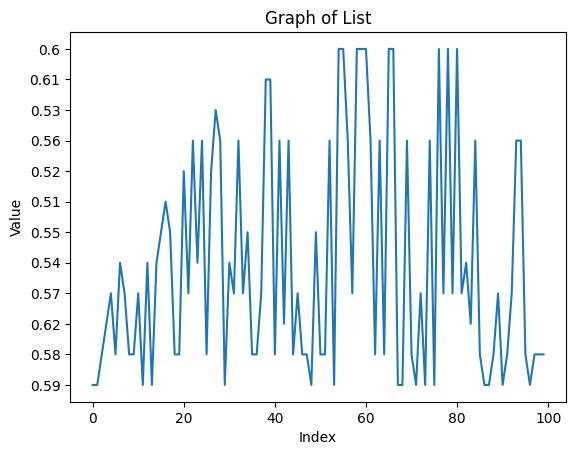

In [21]:
# Plotting the graph
plt.plot(valid_accuracyWhere)

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Graph of List')

# Show the plot
plt.show()

In [20]:
save_checkpoint(modelWhere, optimizer, filename='models\\modelWhere_100000_epoch_100_lr_002_accuracy_valid__ckpt.pth.tar')

=> Saving checkpoint


In [99]:
def predict(modelwho, modelwhere, board:chess.Board, forceRight=True):
    legal_moves = list(board.legal_moves)
    assert(len(legal_moves)!=0)
    board_tensor, move_tensor = board2vec(board)
    board_tensor = torch.from_numpy(board_tensor).unsqueeze(0).to(device)
    move_tensor = torch.from_numpy(move_tensor).unsqueeze(0).to(device)
    
    with torch.no_grad():
        who = modelwho(board_tensor, move_tensor)
    who = who.squeeze().cpu().numpy()
    if forceRight:
        who_map = [i.from_square for i in legal_moves]
        who = sorted([(i, idx) for idx, i in enumerate(who) if idx in who_map], key=lambda x: x[0], reverse=True)
    else:
        who = sorted([(i, idx) for idx, i in enumerate(who)], key=lambda x: x[0], reverse=True)
        
    who = who[0][1] # we can chose via probability of top 2 etc
    assert who in [i.from_square for i in legal_moves]
    who_one_hot = np.zeros((64), dtype=np.float32)
    who_one_hot[who] = 1
    who_one_hot = torch.from_numpy(who_one_hot).unsqueeze(0).to(device)
    
    with torch.no_grad():
        where = modelwhere(board_tensor, move_tensor, who_one_hot)
    where = where.squeeze().cpu().numpy()
    
    if forceRight:
        where_map = [i.to_square for i in legal_moves if i.from_square == who]
        where = sorted([(i, idx) for idx, i in enumerate(where) if idx in where_map], key=lambda x: x[0], reverse=True)
    else:
        where = sorted([(i, idx) for idx, i in enumerate(where)], key=lambda x: x[0], reverse=True)
    where = where[0][1] 
    
    f,t = chess.square_name(who), chess.square_name(where)
    
    if t in ['a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1', 'a8', 'b8', 'c8', 'd8', 'e8', 'f8', 'g8', 'h8']:
        if (board.piece_at(who) == chess.Piece(chess.PAWN, chess.WHITE)):
            move = chess.Move.from_uci(f + t + 'Q')
            return move
        elif (board.piece_at(who) == chess.Piece(chess.PAWN, chess.BLACK)):
            move = chess.Move.from_uci(f + t + 'q')
            return move
    
    move = chess.Move.from_uci(f + t)
    assert move in legal_moves
    return move

In [120]:
predict(modelWHO, modelWhere, board, forceRight=False)

Move.from_uci('e2e4')

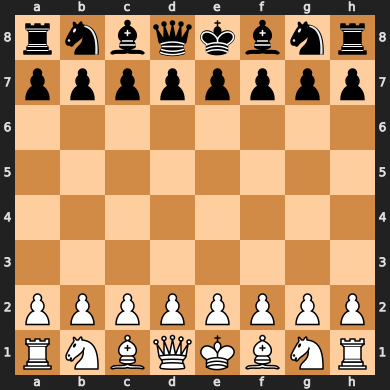

In [121]:
board

In [27]:
board.reset()

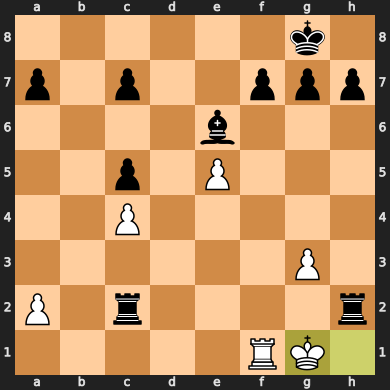

[Event "MakeDataset"]
[Site "ThefCraft"]
[Date "2024-02-02"]
[Round "1"]
[White "Stockfish-1"]
[Black "Stockfish-2"]
[Result "0-1"]

1. e4 e5 2. Nf3 Nf6 3. Nc3 Nc6 4. Bb5 Bb4 5. O-O O-O 6. d4 Bxc3 7. bxc3 Nxe4 8. c4 Nxd4 9. Nxd4 Nc3 10. Nc6 dxc6 11. Qxd8 Rxd8 12. Bxc6 Ne2+ 13. Kh1 bxc6 14. Bd2 Rxd2 15. f3 Be6 16. Rae1 c5 17. Rxe2 Rxe2 18. g3 Rxc2 19. f4 Rd8 20. fxe5 Rdd2 21. Kg1 Rg2+ 22. Kh1 Rxh2+ 23. Kg1 Rcg2# 0-1


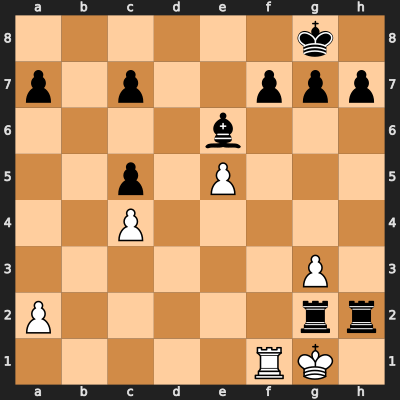

In [127]:
matches = 0
while True:
    matches+=1
    movehistory =[]
    board.reset()
    game = chess.pgn.Game()
    game.headers["Event"] = "MakeDataset"
    game.headers["Site"] = "ThefCraft"
    game.headers["Date"] = str(datetime.datetime.now().date())
    game.headers["Round"] = matches
    game.headers["White"] = "Stockfish-1"
    game.headers["Black"] = "Stockfish-2"
    
    print('*'*50, 'Matches : ', matches, '*'*50)

    while not board.is_game_over():
        clear_output(wait=True)
        display(board)
        time.sleep(.5)
        if not board.turn:
            move = engine.play(board, chess.engine.Limit(time=.000000001)).move
            movehistory.append(move)
            board.push(move)
        else:
            if board.is_game_over(): break
            move = predict(modelWHO, modelWhere, board, forceRight=True)
            movehistory.append(move)
            board.push(move)
    break

game.add_line(movehistory)
game.headers["Result"] = str(board.result())
print(game)
print(game, file=open("test.pgn", "w"), end="\n\n")
SVG(chess.svg.board(board=board,size=400))